# Solving PDEs with Jax - Poisson
## Description
This file contains our first approach to solve PDEs with neural networks on Jax Library.  

### Average time of execution 
Between 2 and 3 minutes on GPU

### PDE
We will try to solve the poisson Equation :  
$-\Delta \psi(x,y) = f(x,y)$ on $\Omega = [0,1]^2$  

### Boundary conditions   
$\psi|_{\partial \Omega}=0$ and $f(x, y)=2\pi^2 sin(\pi x) sin(\pi y)$

### Loss function
The loss to minimize here is $\mathcal{L} = ||\Delta \psi(x,y) + f(x,y)||_2$  

### Analytical solution
The true function $\psi$ should be $\psi(x, y)=sin(\pi x) sin(\pi y)$

### Approximated solution
We want find a solution $\psi(x,y)=F(x,y)N(x,y)+A(x,y)$ s.t:  
$F(x,y)=\sin(x-1)\sin(y-1)\sin(x)\sin(y)$  
$A(x,y)=0$   


# Importing libraries

In [14]:
# Jax libraries
from jax import value_and_grad,vmap,jit,jacfwd
from functools import partial 
from jax import random as jran
from jax.example_libraries import optimizers as jax_opt
from jax.nn import tanh
from jax.lib import xla_bridge
import jax.numpy as jnp

# Others libraries
from time import time
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
print(xla_bridge.get_backend().platform)

gpu


# Multilayer Perceptron

In [15]:
class MLP:
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure
    """
    
    # Class initialization
    def __init__(self,SEED,layers):
        self.key=jran.PRNGKey(SEED)
        self.keys = jran.split(self.key,len(layers))
        self.layers=layers
        self.params = []

    # Initialize the MLP weigths and bias
    def MLP_create(self):
        for layer in range(0, len(self.layers)-1):
            in_size,out_size=self.layers[layer], self.layers[layer+1]
            std_dev = jnp.sqrt(2/(in_size + out_size ))
            weights=jran.truncated_normal(self.keys[layer], -2, 2, shape=(out_size, in_size), dtype=np.float32)*std_dev
            bias=jran.truncated_normal(self.keys[layer], -1, 1, shape=(out_size, 1), dtype=np.float32).reshape((out_size,))
            self.params.append((weights,bias))
        return self.params
        
    # Evaluate a position XY using the neural network    
    @partial(jit, static_argnums=(0,))    
    def NN_evaluation(self,new_params, inputs):
        for layer in range(0, len(new_params)-1):
            weights, bias = new_params[layer]
            inputs = tanh(jnp.add(jnp.dot(inputs, weights.T), bias))
        weights, bias = new_params[-1]
        output = jnp.dot(inputs, weights.T)+bias
        return output
    
    # Get the key associated with the neural network
    def get_key(self):
        return self.key

# Two dimensional PDE operators

In [16]:
class PDE_operators2d:
    """
        Class with the most common operators used to solve PDEs
    Input:
        A function that we want to compute the respective operator
    """
    
    # Class initialization
    def __init__(self,function):
        self.function=function

    # Compute the two dimensional laplacian
    def laplacian_2d(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @partial(jit)    
        def action(params,x,y):
            u_xx = jacfwd(jacfwd(fun, 1), 1)(params,x,y)
            u_yy = jacfwd(jacfwd(fun, 2), 2)(params,x,y)
            return u_xx + u_yy
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        laplacian = vec_fun(params, inputs[:,0], inputs[:,1])
        return laplacian

    # Compute the partial derivative in x
    @partial(jit, static_argnums=(0,))    
    def du_dx(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @partial(jit)    
        def action(params,x,y):
            u_x = jacfwd(fun, 1)(params,x,y)
            return u_x
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        return vec_fun(params, inputs[:,0], inputs[:,1])

    # Compute the partial derivative in y
    @partial(jit, static_argnums=(0,))    
    def du_dy(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @partial(jit)    
        def action(params,x,y):
            u_y = jacfwd(fun, 2)(params,x,y)
            return u_y
        vec_fun = vmap(action, in_axes = (None, 0, 0))
        return vec_fun(params, inputs[:,0], inputs[:,1])

# Physics Informed Neural Networks

In [17]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks
    Input:
        The evaluation function of the neural network
    """

    # Class initialization
    def __init__(self,NN_evaluation):
        self.operators=PDE_operators2d(self.solution)
        self.laplacian=self.operators.laplacian_2d
        self.NN_evaluation=NN_evaluation
        self.dsol_dy=self.operators.du_dy

    # Definition of the function A(x,y) mentioned above
    @partial(jit, static_argnums=(0,))    
    def A_function(self,inputX,inputY):
        return jnp.zeros_like(inputX).reshape(-1,1)

    # Definition of the function F(x,y) mentioned above   
    @partial(jit, static_argnums=(0,))    
    def F_function(self,inputX,inputY):
        F1=jnp.multiply(jnp.sin(inputX),jnp.sin(inputX-jnp.ones_like(inputX)))
        F2=jnp.multiply(jnp.sin(inputY),jnp.sin(inputY-jnp.ones_like(inputY)))
        return jnp.multiply(F1,F2).reshape((-1,1))

    # Definition of the function f(x,y) mentioned above   
    @partial(jit, static_argnums=(0,))    
    def target_function(self,inputs):
        return (2*jnp.pi**2*jnp.sin(jnp.pi*inputs[:,0])*jnp.sin(jnp.pi*inputs[:,1])).reshape(-1,1)

    # Compute the solution of the PDE on the points (x,y)
    @partial(jit, static_argnums=(0,))    
    def solution(self,params,inputX,inputY):
        inputs=jnp.column_stack((inputX,inputY))
        NN = vmap(partial(jit(self.NN_evaluation), params))(inputs)
        F=self.F_function(inputX,inputY)
        A=self.A_function(inputX,inputY)
        return jnp.add(jnp.multiply(F,NN),A).reshape(-1,1)

    # Compute the loss function
    @partial(jit, static_argnums=(0,))    
    def loss_function(self,params,inputs):
        targets = solver.target_function(inputs)
        preds=self.laplacian(params,inputs).reshape(-1,1)
        return jnp.linalg.norm(preds+targets)    

    # Train step
    @partial(jit, static_argnums=(0,))    
    def train_step(self,i, opt_state, inputs):
        params = get_params(opt_state)
        loss, gradient = value_and_grad(self.loss_function)(params,inputs)
        return loss, opt_update(i, gradient, opt_state)

# Initialize neural network

In [18]:
# Neural network parameters
SEED = 351
n_features, n_targets = 2, 1            # Input and output dimension
layers = [n_features,30,n_targets]      # Layers structure

# Initialization
NN_MLP=MLP(SEED,layers)                 
params = NN_MLP.MLP_create()            # Create the MLP
NN_eval=NN_MLP.NN_evaluation            # Evaluate function
solver=PINN(NN_eval)
key=NN_MLP.get_key()

# Train parameters

In [19]:
batch_size = 50
num_batches = 100000
report_steps=1000
loss_history = []

# Adam optimizer
It's possible to continue the last training if we use options=1

In [20]:
opt_init, opt_update, get_params = jax_opt.adam(0.0005)

options=0
if options==0:  # Start a new training
    opt_state=opt_init(params)

else:           # Continue the last training
    # Load trained parameters for a NN with the layers [2,30,1]
    best_params = pickle.load(open("./NN_saves/NN_jax_params.pkl", "rb"))
    opt_state = jax_opt.pack_optimizer_state(best_params)
    params=get_params(opt_state)

# Solving PDE

In [21]:
# Main loop to solve the PDE
for ibatch in range(0,num_batches):
    ran_key, batch_key = jran.split(key)
    XY_train = jran.uniform(batch_key, shape=(batch_size, n_features), minval=0, maxval=1)

    loss, opt_state = solver.train_step(ibatch,opt_state, XY_train)
    loss_history.append(float(loss))

    if ibatch%report_steps==report_steps-1:
        print("Epoch n°{}: ".format(ibatch+1), loss.item())
    if ibatch%5000==0:
        trained_params = jax_opt.unpack_optimizer_state(opt_state)
        pickle.dump(trained_params, open("./NN_saves/NN_jax_checkpoint.pkl", "wb"))


Epoch n°1000:  16.8656005859375
Epoch n°2000:  13.043374061584473
Epoch n°3000:  9.39885139465332
Epoch n°4000:  1.402360439300537
Epoch n°5000:  0.5076846480369568
Epoch n°6000:  0.11085353791713715
Epoch n°7000:  0.06346675753593445
Epoch n°8000:  0.05376172065734863
Epoch n°9000:  0.04813845828175545
Epoch n°10000:  0.04360117390751839
Epoch n°11000:  0.039349690079689026
Epoch n°12000:  0.035346005111932755
Epoch n°13000:  0.03126910701394081
Epoch n°14000:  0.028206845745444298
Epoch n°15000:  0.024211522191762924
Epoch n°16000:  0.021377889439463615
Epoch n°17000:  0.019194817170500755
Epoch n°18000:  0.0172917228192091
Epoch n°19000:  0.015774047002196312
Epoch n°20000:  0.014490223489701748
Epoch n°21000:  0.013443739153444767
Epoch n°22000:  0.012545859441161156
Epoch n°23000:  0.011805604211986065
Epoch n°24000:  0.011204875074326992
Epoch n°25000:  0.010676281526684761
Epoch n°26000:  0.010222324170172215
Epoch n°27000:  0.009843493811786175
Epoch n°28000:  0.009519227780401

# Plot loss function

<function matplotlib.pyplot.show(close=None, block=None)>

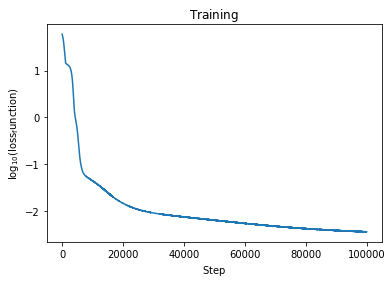

In [22]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(loss_history))
xlabel = ax.set_xlabel(r'${\rm Step}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss_function)}$')
title = ax.set_title(r'${\rm Training}$')
plt.show

# Approximated solution
We plot the solution obtained with our NN

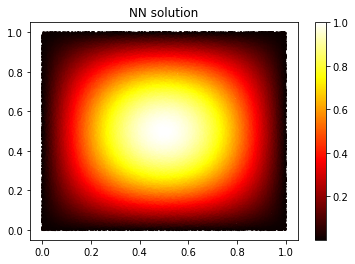

In [23]:
plt.figure()
params=get_params(opt_state)
n_points=100000
ran_key, batch_key = jran.split(key)
XY_test = jran.uniform(batch_key, shape=(n_points, n_features), minval=0, maxval=1)

predictions = solver.solution(params,XY_test[:,0],XY_test[:,1])
plt.scatter(XY_test[:,0],XY_test[:,1], c=predictions, cmap="hot",s=2)
plt.clim(vmin=jnp.min(predictions),vmax=jnp.max(predictions))
plt.colorbar()
plt.title("NN solution")
plt.show()

# True solution
We plot the true solution, its form was mentioned above

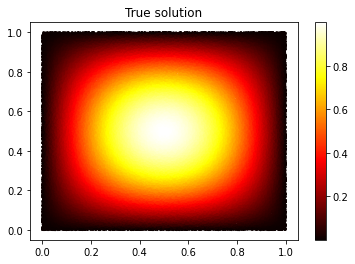

In [24]:
def true_solution(inputs):
    return jnp.sin(jnp.pi*inputs[:,0])*jnp.sin(jnp.pi*inputs[:,1])

plt.figure()
n_points=100000
ran_key, batch_key = jran.split(key)
XY_test = jran.uniform(batch_key, shape=(n_points, n_features), minval=0, maxval=1)

true_sol = true_solution(XY_test)
plt.scatter(XY_test[:,0],XY_test[:,1], c=true_sol, cmap="hot",s=2)
plt.clim(vmin=jnp.min(true_sol),vmax=jnp.max(true_sol))
plt.colorbar()
plt.title("True solution")
plt.show()

# Absolut error
We plot the absolut error, it's |true solution - neural network output|

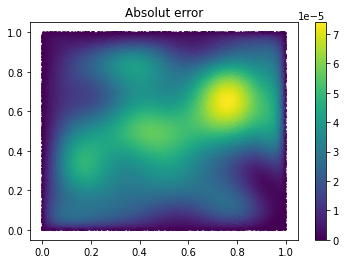

In [25]:
plt.figure()
params=get_params(opt_state)
n_points=100000
ran_key, batch_key = jran.split(key)
XY_test = jran.uniform(batch_key, shape=(n_points, n_features), minval=0, maxval=1)

predictions = solver.solution(params,XY_test[:,0],XY_test[:,1])[:,0]
true_sol = true_solution(XY_test)
error=abs(true_sol-predictions)

plt.scatter(XY_test[:,0],XY_test[:,1], c=error, cmap="viridis",s=2)
plt.clim(vmin=0,vmax=jnp.max(error))
plt.colorbar()
plt.title("Absolut error")
plt.show()

# Save NN parameters

In [26]:
trained_params = jax_opt.unpack_optimizer_state(opt_state)
pickle.dump(trained_params, open("./NN_saves/NN_jax_params.pkl", "wb"))